### Quick Intro

This is my first Kaggle competition! After doing the [kaggle.com spaCy-course for NLP](https://www.kaggle.com/learn/natural-language-processing) I felt inspired to try out my new knowledge in this competition.
Additionally there is an almost "ready for use" code example for using spaCy NAMED ENTITIY RECOGNIZER: https://spacy.io/usage/training#ner

Please feel free to give me some hints for improvements in all categories: making code more "pythonic", better plots, ideas for post-processing, etc.

Warning: Following text may contain Star Trek references.


Final edit:
Added some insights, finalized wording, optimized section order slightly.

# Competition description
With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company or a brand positively or negatively. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.  
The objective in this competition is to construct a model that can look at a given tweet and the already assigned sentiment and figure out what word or phrase best supports the sentiment. What words in tweets support a positive, negative, or neutral sentiment? How can you help make that determination using machine learning tools?

### What should I expect the data format to be?
Each row in the dataset contains the text of a tweet and a sentiment label. In the training set we are provided with a word or phrase drawn from the tweet (selected_text) that determins and encapsulates the provided sentiment.

### What am I predicting?
We are attempting to predict the word or phrase from each tweet that determines and exemplifies the provided sentiment. The word or phrase should include all characters within that span (i.e. including commas, spaces, etc.). It's only one span per tweet: the word or phrase starts somewhere and ends somewhere without being interrupted in between.

For example:

> 2,  "very good"  
> 5,  "I am neutral about this"  
> 6,  "bad"  
> 8,  "if you say so!"  
> etc.  

# Table of Contents
1. **Preparations**
   - 1.1 Importing dependencies & loading data-sets
   - 1.2 First glimps on data and dealing with missing values
2. **Explorative Data Analysis**
   - 2.1 Distribution of sentiments in train and test data.
   - 2.2 Distribution of number of words in train data
   - 2.3 Distribution of number of words per sentiment in train data
   - 2.4 How is len(selected_text) related to len(text) per sentiment?
   - 2.5 Check how the difference of length relates to the length of the tweets 
3. **Content & language analysis**
   - 3.1 Interpunctuation & special characters
   - 3.2 Slang, wording, typos & unusual words-analysis
   - 3.3 Which words in our data are *NOT* in a vocab?
   - 3.4 Jaccard Scores for taking "text" as "selected_text" in train-data
   - 3.5 Submission: Setting the Baseline Score: Jaccard Scores for using "TEXT" as "SELECTED_TEXT"
4. **Modelling & predicting with spaCy**
   - 4.1 Modelling with spaCy
   - 4.2 Evaluating the achieved predictions
5. **Conclusion**
6. **Creating submission_df to hand in our solution!**

# 1. Preparations
## 1.1 Importing dependencies & loading data-sets
<span style="color:darkgreen ;font-family: Impact; font-size:13;"> from  </span> coffee  <span style="color:darkgreen ;font-family: Impact; font-size:13;"> import  </span> ***** 

In [ ]:
## Import & install needed packages & libraries
import numpy as np # algebra
import pandas as pd # data frames & processing, CSV file I/O 

# Visualization, graphs & plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go # plots & graphics 
from plotly.subplots import make_subplots 
import seaborn as sns # plots & graphics

# SpaCy
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from thinc.neural.optimizers import Adam # for hyperparameter tuning
from thinc.neural import Model # for hyperparameter tuning

# Utilities & helpers
from tqdm import tqdm_notebook as tqdm # progress bar
import time
import os
import re # Regex library
import random
import timeit # measuring execution time
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

In [ ]:
# Load data: Go to parent directory (../), re-dicrect to train & test.csv
DATA_BASE_PATH = '../input/tweet-sentiment-extraction/' 

# Read training & test data as pandas-dataframe (ending _df)
train_df = pd.read_csv(DATA_BASE_PATH + 'train.csv') 
test_df = pd.read_csv(DATA_BASE_PATH + 'test.csv')

In [ ]:
print(f"Train-Data shape is: {train_df.shape}") 
print(f"Test-Data shape is: {test_df.shape}")
# Link for knowledge about Python 3.6+ new f-string formatting:
# https://realpython.com/python-f-strings/

## 1.2 First glimps of data and dealing with missing values

In [ ]:
# First glimps of the train data
train_df.head()

In [ ]:
# First glimps of the test data
test_df.head()

### Checking for missing values

In [ ]:
# Checking for missing values
print(f"Missing values in TRAIN_data: \n" + "-" * 25)
print(f"{train_df.isna().sum()}")

print(f"\n \n" + "Missing values in TEST_data: \n" + "-" * 25)
print(f"{test_df.isna().sum()}")

# Show all rows containing missing values:
# Reminder using pandas: sum(axis = 1) sums up along the X axis
print(f"\n \n {train_df[train_df.isna().sum(axis = 1) >= 1]}")   

Nothing missing in test_data.  
Only 2 missing values (in the same row) in train data.
As just one row (#314) of the data contained missing values, in-place dropping of that row is ok.

In [ ]:
train_df.dropna(inplace = True, how = 'any')

# 2 Exploratory Data Analysis
#### As there are already some very good EDA-focused notebooks, I try to minimize EDA here to what is *new* and necessary and remove some stuff which I did along the path.
Here my top favorites for a more complete EDA:  
[ EDA and Preprocessing for BERT](https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert) by Parul  
[Complete EDA & Baseline model [0.708 LB] ](https://www.kaggle.com/shahules/complete-eda-baseline-model-0-708-lb) by Shahules786  
[Twitter sentiment Extaction-Analysis,EDA and Model ](Twitter sentiment Extaction-Analysis,EDA and Model) by MrKnowNothing

### First orientation: Let's get some hints on what to look for in our EDA.

Let's run the line below a few times and check some rows to get some hints on what to look for & learn about the data.
Based on this, we can structure our further analysis.

In [ ]:
train_df.sample(15)

### Some quick findings:
1. ```selected_text```  of **neutral** tweets seems to be **longer** than for positive or negative tweets.
2. ``` selected_text```  of **neutral** tweets seems to have a very **high overlap** / Jaccard Score with ``` text```. They also seem to have a higher overlap than positive and negative tweets.
3. ``` selected_text```  **contains interpunctuation** in general - removing it would not be a good idea. 
4. Some ``` selected_text```  entries **contain unexpected interpunctuation**.   
> E.g. line 9079: ``` seletect_text```  = *". Probably spelt it wrong lol."*
5. Some ``` selected_text```  entries **contain unexpected chars** and/or are **cut off**:   
> E.g. line 751: ``` seletect_text```  = *"t sucks"*


### So what are we going to look for:
1. Distribution of **sentiments** in train and test data.
2. Distribution of **number of words in train**_df.
3. Distribution of **number of words per sentiment** category.
4. **Difference between len(``` text``` ) and len(``` selected text``` )** per sentiment: As we can see at that least **neutral** sentiments look rather special (see finding no.2).
5. ```selected_Text```  **Content & Language Analysis**: interpunctuations, special characters, slang and unique data-set words which are *not* available in a big vocab/dictionary
6. **Avg. Jaccard Score** for each sentiment if we use the complete ``` text```  as ``` selected_text```  for training data --> this will give us a lower boundary for our model's estimations.
7. **Avg. public Jaccard Score** for each sentiment if we use the complete ``` text```  as``` selected_text``` --> this will give us a Baseline Jaccard Score (lower boundary) for our model's estimations.


### Due to many funny/sad or surprising rows, I felt the urge to start a short top list:

In [ ]:
train_df.loc[[9710]] # cheese

So part of our task is to teach an algorithm the following realtionship, which is not clearly understandable for humans:
<img width="100">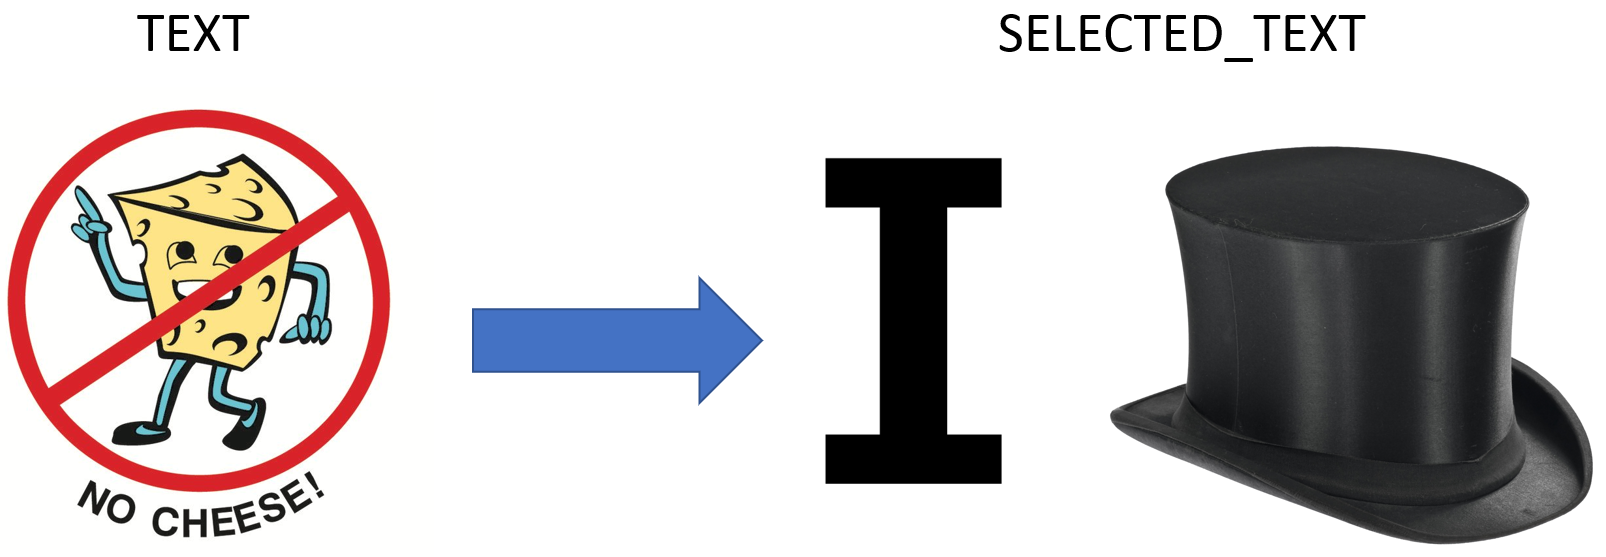

In [ ]:
train_df.loc[[1305]] # live long

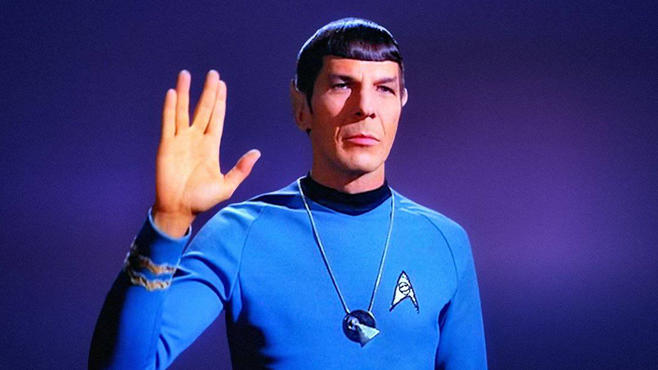 

I guess Spock's sentiment would be rather "neutral" (or maybe even negative?) if he sees his most memorable quote split into two.  
“Live long and prosper.” - First spoken in Star Trek, season 2, episode 1 (“Amok Time,” 1968)

After defining the structure of what we want to look at, let's start with analysis no.1.

## 2.1 Distribution of sentiments in train and test data

In [ ]:
train_absolute_count = train_df["sentiment"].value_counts()
train_relative_count = train_df["sentiment"].value_counts(normalize = True)
test_relative_count = test_df["sentiment"].value_counts(normalize = True)

# Create figure and add traces
fig = make_subplots(1,3, subplot_titles = ('TRAIN data absolute amount',
                                           'TRAIN data relative amount', 
                                           'TEST data relative amount'))
for i in fig['layout']['annotations']:
            i['font'] = dict(size = 13)
  
fig.add_trace(go.Bar(x = train_absolute_count.index, y = train_absolute_count.values, 
                     marker_color = ['blue','green','red'], name= ''), row = 1, col = 1)

fig.add_trace(go.Bar(x = train_relative_count.index, y = train_relative_count.values,                     
                     marker_color = ['blue','green','red'], name= ''), row = 1, col = 2)

fig.add_trace(go.Bar(x = test_relative_count.index, y = test_relative_count.values,
                     marker_color = ['blue','green','red'], name= ''), row = 1, col = 3)


title_text = "Absolut and relative distribution of sentiments in train and test data"
fig.update_layout(title={'text': title_text})

# Define default go-layout for future use
default_layout =  go.Layout(  
    title = {                    
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    titlefont = {
     'size' : 15, 
     'color': 'black'
    },
    font = {
      'size' : 10 
    })

fig.update_layout(default_layout)

fig.show()

**Findings:**
* **Neutral**: 40,5%  
* **Positive**: 31,2%  
* **Negative**: 28,3%**  

* **TEST and TRAIN data** share **almost identical distribution** concerning the sentiments.

## 2.2 Distribution of number of words in train data

I first created a histo using matplotlib, but it took me many lines of code and looked ugly. If you want to see it: comment-in the hidden code. **Using seaborn** seems to be the way to go: fast and nice.
Check out the following links for <span style="color:orange"> **Seaborn Tutorials & examples**: </span>  

https://www.kaggle.com/kralmachine/seaborn-tutorial-for-beginners  
https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/    
https://seaborn.pydata.org/generated/seaborn.kdeplot.html  

In [ ]:
cache = """
train_max_len = max(train_df["TEXT_number_of_words"])
bins = np.linspace(0, train_max_len, train_max_len) # np.linspace takes following arguments: startpoint, endpoint, number of steps

# Cache tbd removed?
cache = plt.hist(train_df["TEXT_number_of_words"], bins, alpha=0.5, label = 'Number of words in "TEXT"')
cache = plt.hist(train_df["SELECTED_TEXT_number_of_words"], bins, alpha=0.5, label = 'Number of words in "SELECTED_TEXT"')
cache = plt.legend(loc = 'upper right')
cache = plt.style.use('seaborn-deep')
plt.gcf().set_size_inches(15, 7)  # Wow, there's really no set_size_cm ...but yea, a conversion via a pre-defined tuple could help here.
cache = plt.show()
"""

In [ ]:
# Create columns with number of words in 'text' and 'selected_Text'
train_df["TEXT_number_of_words"] = train_df["text"].apply(lambda x: len(str(x).split()))  
train_df["SELECTED_TEXT_number_of_words"] = train_df["selected_text"].apply(lambda x: len(str(x).split()))
train_max_len = max(train_df["TEXT_number_of_words"])

fig = plt.figure(figsize=(18,8))
# Number of bins shall equal the max-length in train_df['text']
bins = np.linspace(0, train_max_len, train_max_len) 
# sns.distplot is a nice combination of sns.hist and sns.kdplot
plot1 = sns.distplot(train_df['TEXT_number_of_words'], 
                     bins = bins, 
                     label = 'TEXT_number_of_words')
plot1 = sns.distplot(train_df['SELECTED_TEXT_number_of_words'], 
                     bins =  bins,  
                     label = 'SELECTED_TEXT_number_of_words')  
cache = plt.legend() 

fig.suptitle('Distribution of number of words', fontsize = 20)

# Defining default parameter for plt.rc for later re-use.
params = {
    'figure.titlesize': 22, # fontsize of plot title / fig.suptitle
    'axes.titlesize': 14,   # fontsize of the axes title
    'axes.labelsize': 11,   # fontsize of the x and y labels    
    'xtick.labelsize': 11,  # fontsize of the tick labels
    'ytick.labelsize': 11,  # fontsize of the tick labels
    'legend.fontsize': 12,  # fontsize for legends (plt.legend(), fig.legend())
}

plt.rcParams.update(params)

**Findings:**
* Most ```selected_text``` entries consist of less than 10 words.
* The most frequently observed length of ```selected_text``` is just one word.
* Most tweets ```text``` length is between 5 and 25 words.
* As many other notebooks described, the ```text``` length in TEST-data is similar to what we see in train-data.

## 2.3 Distribution of number of words per sentiment in train data

In [ ]:
sentiments = ['neutral', 'negative', 'positive']
fig,ax = plt.subplots(nrows = 1, ncols = len(sentiments), figsize = (20,5))

for i, sentiment in enumerate(sentiments):
    plot2 = sns.kdeplot(train_df[train_df['sentiment'] == sentiment]['TEXT_number_of_words'],
                        ax = ax[i],
                        label = 'TEXT wordcount').set_title(sentiment) 
    plot2 = sns.kdeplot(train_df[train_df['sentiment'] == sentiment]['SELECTED_TEXT_number_of_words'],  
                        ax = ax[i],
                        label = 'SELECTED_TEXT wordcount') 
    ax[i].set_xlabel('Number of words')
    cache = plt.legend() 

fig.suptitle('Words in TEXT and SELECTED_TEXT', fontsize = 20)

params_3_figs = {
    'figure.titlesize': 18, # Fontsize of plot title / fig.suptitle
    'axes.titlesize': 14,   # Fontsize of the axes title
    'axes.labelsize': 14,   # Fontsize of the x and y labels    
    'xtick.labelsize': 14,  # Fontsize of the tick labels
    'ytick.labelsize': 14,  # Fontsize of the tick labels
    'legend.fontsize': 14,  # Fontsize for legends (plt.legend(), fig.legend())
}

plt.rcParams.update(params_3_figs) # Params defined above and re-used.

**Quick explanation**:  
The KDE (kernel density estimation) is an *estimate* (based on our train_df as a sample) for the probability density function (PDF).  
The probability density function "can be interpreted as providing a relative likelihood that the value of the random variable would equal that sample" (perfect wording, found on Wikipedia)

**Findings:**
* The plotted KDEs show:
* For **neutral**-sentiment the (estimated) probability for each length for ```text``` and ```selected_text``` is almost the same.
* For **positive** and **negative**-sentiment, the KDE is strongly right-skewed (having a long right trail) and short ```selected_text```s do have the highest estimated probability.

This is not yet telling us the *correlation* between len(```text```) and len(```selected_text```), but shows that neutral is behaving very differently from negative and positive, while positive and negative KDE is quite similar.  
So let's dig deeper:
* How is the len(```selected_text```) related to len(```text```) per sentiment?
* Let's use the difference between len(```text```) and len(```selected_text```) as a measure of correlation to gain another point of view.

<font size="0.6">
Side note for statistical purists:   
Using a KDE or PDF above is actually not the perfect solution. As we have a discret (and not a continuous) variable (length of text), we should go for a probability *distribution* function rather than for a *density* function. You could do that with searborn using "sns.distplot(train_df, kde = False)". As the graphical result is optically harder to interprete, I allowed myself to use the less perfect solution using a PDF here.
</font>

## 2.4 How is len(```selected_text```) related to len(```text```) per sentiment?


In [ ]:
grid = sns.FacetGrid(train_df, col = 'sentiment', height = 8)
sns_default_font_scale = 1.6 # setting default font scale for sns for later use
grid.map(sns.lineplot, 'TEXT_number_of_words', 'SELECTED_TEXT_number_of_words', estimator = 'mean', ci = None)
grid.add_legend() 
plt.subplots_adjust(top = 0.8)
sns.set(font_scale = sns_default_font_scale) 
cache = grid.fig.suptitle('Mean number of words in "SELECTED_TEXT" over number of words in "TEXT"', fontsize = 24)

**Quick explanation**:  
The ```sns.lineplot``` shows the *mean* len(```selected_text```) over len(```text```). For more info see: [Docs](https://seaborn.pydata.org/generated/seaborn.lineplot.html).

**Findings:**
* For **neutral**-sentiment the mean len(```selected_text```) is strongly scaling with len(```text```). We can see that the slope is mostly constant and roughly 1. This underlines our assumption, that ```selected_text``` is mostly equal to ```text``` for **neutral**-sentiment.
* For **positive** and **negative**-sentiment, the mean len(```selected_text```) is also increasing with len(```text```), but with a slope much smaller than 1. We can also see much more jumps in the mean len(```selected_text```) for longer tweets. In the next step, let's check out these jumps: let's first plot the difference in length for ```text``` and ```selected_text``` and then plot the **distribution** of the difference in length. Most probably the jumps derive from having a wide range of len(```selected_text```) for longer tweets.

## 2.5 Let's check how the difference of length relates to the length of the tweet's text

In [ ]:
# Creating column with the difference of number of words in 'text' and 'selected text'
train_df['Diff_len_text_selected_text'] = train_df['TEXT_number_of_words'] - train_df['SELECTED_TEXT_number_of_words']

In [ ]:
grid = sns.FacetGrid(train_df, col = 'sentiment', height = 8)
sns.set(font_scale = sns_default_font_scale) 
grid.map(sns.lineplot, 'TEXT_number_of_words', 'Diff_len_text_selected_text', ci = None)
grid.add_legend()
plt.subplots_adjust(top = 0.8)
cache = grid.fig.suptitle('Difference of len(TEXT) and len(SELECTED_TEXT) over number of words in "TEXT"', fontsize = 24)

**Quick explanation**:  
This ```sns.lineplot``` shows the *mean difference* of len(```selected_text```) and len(```text```) over the tweets len(```text```). For more info see: [Docs](https://seaborn.pydata.org/generated/seaborn.lineplot.html).

**Findings:**
* For **neutral**-sentiment the mean difference in length is very small and again underlining our initial assumption that ```text``` might be a good estimate for ```selected_text```. However, we can see again that for tweets with around 22-29 words we have more bumps and a bigger mean difference in length.

* For **positive** and **negative**-sentiment, the mean difference in length is strongly scaling with len(```text```): So we can expect that we have to predict more often shorter ```selected_text```for longer tweets when the sentiment is not **neutral**. Furthermore we can see much more bumps in the mean len(```selected_text```).

To get a better feeling of how the difference in length is distributed, let's check the distribution with a boxplot diagram.

In [ ]:
fig_box = go.Figure()

for _, sentiment in enumerate(sentiments):
    # CHANGE HERE! You can change "Diff_len_text_selected_text" in below line to 
    # "TEXT_number_of_words" or "SELECTED_TEXT_number_of_words" to get the respective boxplots.  
    fig_box.add_trace(go.Box(y = train_df[train_df['sentiment'] == sentiment]['Diff_len_text_selected_text'], name = sentiment)) 

title_text = 'Boxplot diagram difference in len(text) and len(selected_text)'
fig_box.update_layout(title = {'text': title_text})
fig_box.update_layout(default_layout)
          
fig_box.show()

**Quick explanation**:  
![](https://i2.wp.com/flowingdata.com/wp-content/uploads/2008/02/box-plot-explained.gif?w=1090)
[Source for picture](https://flowingdata.com/2008/02/15/how-to-read-and-use-a-box-and-whisker-plot/)

Median: The median is dividing the data into two equally sized halves, so that half of the tweets are shorter than the median and half are longer.

**Findings:**
* For **neutral**-sentiment: The median is 0 and so is the upper quartil. We have quite some outliers but our hypothesis of ```text``` beeing a good estimator for ```selected_text``` is again supported.

For **positive** and **negative**-sentiment: 
1.  The boxplots are almost identical: Half of the difference between len(```selected_text```) and len(```text```) is smaller than 9 words, the other half is bigger.
2. 25% of the tweets have a difference in length bigger than 15 (upper quartile).
3. 25% of the tweets have a difference in length smaller than 4 (lower quartile).

We have seen and learned a lot about the given dataset which we can use for building the model and for post processing.
As a next step, let's go for some content and language analysis.

Note: if you want to see the boxplots for ```text``` and ```selected_text```, you just need to expand above code cell and do a minor copy-paste change, as indicated in the comment.

# 3 Content & language analysis
### What we are going to look for:
1) Interpunctuation & special characters. Lets find out what their impact is.  
2) Slang, wording & typos - let's find words that are uncommon in a typical web-dictonary. 

### 3.1 Interpunctuation & special characters 
Let's catch some examples for strange interpunctuaion in ```selected text``` with a RegEx-using function.



In [ ]:
## Defining functions for using RegEx
def startsOrEndsWithSpecialCharacter(rowString): 
    '''
    Returns a boolean for whether a given string starts OR ends with an unexpected characters
    '''
    # Check beginning of the string
    pattern = '^[\/_,.|;:#*~+-?!].*'
    value =  0 if (re.match(pattern, rowString) == None) else 1
    # Check ending: expected interpunctuation at the end of the selected text (! ? .) is allowed.  
    pattern = '.*[\/_,|;:#*~+-]$' 
    value = value | (0 if (re.match(pattern, rowString) == None) else 1)
    # Check ending for white spaces before ending on a spec. character. E.g. "hi ."
    value = value | endsWithAppendedSpecialCharactersAndWhitespace(rowString) 
    # print(re.match(pattern, rowString)) # for analysis, if needed
    return value

In [ ]:
# Some additional functions for extending the analysis if needed.

# looking for stuff like ', so happy'
def startsWithPrependedSpecialCharactersAndWhitespace(rowString):   
    pattern = '(^[\/_|,;.:#*~+-!?]\s+.*)'
    # print(re.match(pattern, rowString)) 
    return 0 if (re.match(pattern, rowString) == None) else 1

# looking for stuff like ',so happy'
def startsWithPrependedSpecialCharactersNoWhitespace(rowString): 
    pattern = '(^[\/_|,;.:#*~+-](?!\s+).*)'
    # print(re.match(pattern, rowString))
    return 0 if (re.match(pattern, rowString) == None) else 1

# looking for stuff like 'so happy,') 
# expected interpunctuation at the end of the selected text (! ? .) is allowed
def endsWithAppendedSpecialCharactersNoWhitespace(rowString):  
    pattern = '.*(<\s)[\/_|,;:#*~+-]$'  
    # print(re.match(pattern, rowString))
    return 0 if (re.match(pattern, rowString) == None) else 1

# looking for stuff like 'so happy ,') 
def endsWithAppendedSpecialCharactersAndWhitespace(rowString):  
    pattern = '(.*\s+)?[\/_,.|;:#*~+-?!]$'
    # print(re.match(pattern, rowString))
    return 0 if (re.match(pattern, rowString) == None) else 1

In [ ]:
startsOrEndsWithSpecialCharacter_series = []
startsOrEndsWithSpecialCharacter_series = train_df["selected_text"].apply(lambda x: startsOrEndsWithSpecialCharacter(x))
startsOrEndsWithSpecialCharacter_series = startsOrEndsWithSpecialCharacter_series[startsOrEndsWithSpecialCharacter_series > 0]
startsOrEndsWithSpecialCharacter_len = len((startsOrEndsWithSpecialCharacter_series[startsOrEndsWithSpecialCharacter_series == 1]))
print(f"There are {startsOrEndsWithSpecialCharacter_len} tweets"
      f"(= {startsOrEndsWithSpecialCharacter_len/train_df.shape[0] * 100:.2}%) that start or end with a special character pattern. \n"
      "Some examples look like this:")
train_df.loc[startsOrEndsWithSpecialCharacter_series.index].sample(10)[["textID", "text", "selected_text", "sentiment"]]

In [ ]:
nonNeutralSentiment_df = train_df[train_df["sentiment"] != "neutral"]
nonNeutralSentimentsStartEndWithSpecialChar = nonNeutralSentiment_df.loc[nonNeutralSentiment_df.index.intersection(startsOrEndsWithSpecialCharacter_series[startsOrEndsWithSpecialCharacter_series == 1].index)]
print(f"There are {len(nonNeutralSentiment_df)} non-neutral sentiment tweets" 
      f" and {len(nonNeutralSentimentsStartEndWithSpecialChar) / len(nonNeutralSentiment_df) * 100:.1f}%"
      f" END with a special character")

**Findings:**
* While overall only 2251 tweets are affected by starting or ending with a special (and unexpected) character, we can still see that most of them are in non-neutral sentiment tweets. Roughly 8% of all non-neutral sentiment tweets are affected!
* Special characters and interpunctuation patterns might very well have a big impact on our model creation and overall score - most certainly they will be a big focus in the post processing.

Btw: There is a good notebook counting "lonely" interpunctuation-characters here:
[What The No*ise?](https://www.kaggle.com/debanga/what-the-no-ise) by Zenfiy


## 3.2 Slang, wording & typos
The idea in the next few lines of code is to compare our words in ```text``` and ```selected_text``` to a big existing vocab from spaCy. With this we can identify unusual words and on our way to achieve this we can see how many unique words (stripped from interpunctuation) our dataset contains.

But: why spaCy? 
1. The [vocab from the large spaCy model](https://spacy.io/models/en#en_core_web_lg) consists of the corpus from [OntoNotes](https://catalog.ldc.upenn.edu/LDC2013T19)/CommonCrawl containing data from blogs, news, comments and webblogs. For this task this seems to be the better solution than going for a vocab derived from perfectly written and reviewd Wikipedia-articels.
2. We are anyway going to use a spaCy model later ;).

Let's have a look if special-language is common in ```selected_text```: let's check, which words in selected_text are NOT available in spaCys biggest dictionary.

In [ ]:
## Loading the spaCy model
# Model options: small, med, large, see: https://spacy.io/models/en
spaCy_model = 'en_core_web_lg' 
nlp = spacy.load(spaCy_model)

In [ ]:
## Creating spaCy vocab set
spaCy_vocab_list = (list(nlp.vocab.strings))
# set ensures that all values are unique. All words converted to lower case.
spaCy_vocab_set = set([word.lower() for word in spaCy_vocab_list])

In [ ]:
print(f"The loaded spaCy vocab {spaCy_model} contains unique lower case words: {len(spaCy_vocab_set)}")

Let's clean the data(remove special characters and interpunctuation) before we try to identify unique words, so that "*...what?*" is not matched as "unique" but is the same as "*what*".

In [ ]:
def remove_special_characters(str1):
    '''
    Takes a string, removes(substituted by "") all special characters and URLS and returns it.
    '''
    url_pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    # Remove URLs with re.sub(pattern, replacement, string)
    cache = re.sub(url_pattern, ' ', str(str1))  
    # Removing spec. characters
    character_pattern = '\||\,|\;|\.|\:|\#|\*|\~|\+|\-|\/|\_|\?|\!|\"|\'|\`|\(|\)|\=|\&|\%|\$|\§' 
    return re.sub(character_pattern, ' ', str(cache))

In [ ]:
# Create new columns for clean data
train_df['clean_text'] = train_df['text'].str.lower().apply(remove_special_characters)
train_df['clean_selected_text'] = train_df['selected_text'].str.lower().apply(remove_special_characters)
test_df['clean_text'] = test_df['text'].str.lower().apply(remove_special_characters)

# Create sets with unique words and update them 
train_text_vocab_set = set()
train_selected_text_vocab_set  = set()
test_text_vocab_set  = set()

# Apply set.update to fill the sets
train_df['clean_text'].str.lower().str.split().apply(train_text_vocab_set.update)
cache = train_df['clean_selected_text'].str.lower().str.split().apply(train_selected_text_vocab_set.update)
cache = test_df['clean_text'].str.lower().str.split().apply(test_text_vocab_set.update)

In [ ]:
print(
    f"The used spaCy model contains unique words: {len(spaCy_vocab_set)}  \n"
    f"TRAIN-datas 'text' column contains unique words: {(len(train_text_vocab_set))}  \n"
    f"TRAIN-datas 'selected_text' column contains unique words: {len(train_selected_text_vocab_set)} \n"
    f"TEST-datas 'selected_text' column contains unique words: {len(test_text_vocab_set)} \n"
)

In the next step we calculate the fraction of words which are available in both, our data *and* the spaCy model, aswell as the fraction which is available in train *and* test ```text```.

In [ ]:
# Calculate the fraction of words contained in both sets for relevant pairs
fraction_shared_words_train_text_to_spaCy = len(train_text_vocab_set.intersection(spaCy_vocab_set)) / (len(train_text_vocab_set))
fraction_shared_words_train_selected_text_spaCy = len(train_selected_text_vocab_set.intersection(spaCy_vocab_set)) / (len(train_selected_text_vocab_set))
fraction_shared_words_test_text_spaCy = len(test_text_vocab_set.intersection(spaCy_vocab_set)) / (len(test_text_vocab_set))
fraction_shared_words_test_text_train_text = len(test_text_vocab_set.intersection(train_text_vocab_set)) / (len(test_text_vocab_set))

In [ ]:
fig = go.Figure([go.Bar(x = ["train['text'] & spaCy", "train['selected_text'] & spaCy", "test['text'] & spaCy", "test['text'] & train['text']"], 
                        y = [fraction_shared_words_train_text_to_spaCy, fraction_shared_words_train_selected_text_spaCy, fraction_shared_words_test_text_spaCy, fraction_shared_words_test_text_train_text], 
                        marker_color = ['blue','green','red'])])

title_text = 'Fraction of words contained in both sets for relevant pairs'
fig.update_layout(title={'text': title_text})
fig.update_layout(default_layout)
 
fig.show()

**Findings for large spaCy vocab:**
* Train ```text``` and train ```selected_text``` have rougly 85% common words with spaCys big vocab. That still makes roughly 15% of words NOT contained in the biggest spaCy vocab.
* The test ```text``` has a higher overlap: almost 93% of all words are also available in spaCys vocab, leaving just ~7% of "new" words.
* If we now check the bar on the right: TEST and TRAIN ```text``` seem to be quite different, as they have only ~75% overlap!

One last step before we focus on the words, which are NOT in the spaCy vocab:    
What happens, if we check for the fraction of the *cleaned* dataset of ```train['selected_text']``` which is also in ```train[text]```?  
Should be 100%, as ```selected_text``` is derived from ```text```, right?    
No! As we saw earlier, the ```selected_text``` is sometimes strangely cut off. Let's check that quickly before we move on.

In [ ]:
print(f"Only {len(train_selected_text_vocab_set.intersection(train_text_vocab_set)) / (len(train_selected_text_vocab_set)):.4f}%"
      f" of 'selected_text' is fully available in 'text',.. giving us {len(train_selected_text_vocab_set - train_text_vocab_set)} words which are cut off: \n")
print(train_selected_text_vocab_set - train_text_vocab_set)

## 3.3 Which words in our data are *NOT* in a vocab?


In [ ]:
## Create lists, which contain only the not-shared words but which preserve the number of occurences of those words
train_clean_text_word_list = ' '.join([i for i in train_df['clean_text']]).split()  
train_clean_selected_text_word_list = ' '.join([i for i in train_df['clean_selected_text']]).split()  
test_clean_text_word_list = ' '.join([i for i in test_df['clean_text']]).split()  

# Calculate differences 
not_shared_train_text_to_spaCy = [word for word in train_clean_text_word_list if ((word in train_text_vocab_set) and (word not in spaCy_vocab_set))]
not_shared_train_selected_text_to_spaCy = [word for word in train_clean_selected_text_word_list if ((word in train_selected_text_vocab_set) and (word not in spaCy_vocab_set))]
not_shared_test_text_to_spaCy = [word for word in test_clean_text_word_list if ((word in test_text_vocab_set) and (word not in spaCy_vocab_set))]
not_shared_test_text_to_train_text = [word for word in test_clean_text_word_list if ((word in test_text_vocab_set) and (word not in train_text_vocab_set))]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_train_text_to_spaCy ))
titleFontsize = 20

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Not shared words: train_text and spaCy vocab',fontsize = titleFontsize);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_train_selected_text_to_spaCy))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not shared words: train_selected_text and spaCy vocab',fontsize = titleFontsize)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_train_text_to_spaCy ))
titleFontsize = 20

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_test_text_to_spaCy))
ax1.imshow(wordcloud3)
ax1.axis('off')
ax1.set_title('Not shared words: test_text and spaCy vocab',fontsize=titleFontsize);

wordcloud4 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(not_shared_test_text_to_train_text))
ax2.imshow(wordcloud4)
ax2.axis('off')
ax2.set_title('Not shared words: Test_text to train_text',fontsize=titleFontsize)

**Findings:**
* Of course there can't be a notebook without word-clouds if it's really about NLP.
* The first three WordClouds compare ```train[text]```, ```train['selected_text']``` and ```test[text]``` to (large) spaCy vocab. Quite some interesting words are unique in our datasets: followfriday, sanctuarysunday, Musicmonday, starwarsday, twittierville, tweetup.
* The rightmost WordCloud compares: ```test[text]``` to  ```train[text]``` and again we find some interesting unique words.
* We can see that most of the unique words are about starwars or some other typical hashtag-stuff.

Thanks again [Parul](https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert) for sharing a perfect blue-print for Word-Clouds!

In the next section we deal with the Jaccard Score.

Before we go:

Remember:
* The computation of the Jaccard Score happens at the word level.
* The order of words doesn't matter. Same applies for upper or lower case: "yes" is the same as "YES".
* Interpunctuation counts: "YES!" is not the same as "YES"
* The overall evaluation metric of this competition is the mean Jaccard Score over all the entries.

Lets do two things:  
1) Let's calculate the Jaccard Score in *train-data* for each sentiment which we can obtain if we simply use ```text``` as ```selected_text```.  
2) Defining the Baseline Score: Let's check which Jaccard Score we get, when we use ```test[text]``` as ```test[selected_text]``` for our test_df and submit this as our solution.

## 3.4 Jaccard Scores for using "TEXT" as "SELECTED_TEXT" in TRAIN-data

In [ ]:
def jaccard_score (str1, str2):
    '''
    Returns the Jaccard Score (intersection over union) of two strings.
    '''
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    
    return float(len(c) / (len(a) + len(b) - len(c)))  

In [ ]:
train_df["Jaccard_Score_text_selected_text"] = train_df.apply(lambda x: jaccard_score(str(x["text"]), str(x["selected_text"])), axis = 1) 
[avg_Jaccard_neu_train, avg_Jaccard_neg_train, avg_Jaccard_pos_train] = [train_df[train_df["sentiment"] == sentiment]["Jaccard_Score_text_selected_text"].mean() for sentiment in ["neutral", "negative", "positive"]]
avg_Jaccard_train = pd.Series(data = {'Avg Jaccard neutral': avg_Jaccard_neu_train, 'Avg Jaccard negative': avg_Jaccard_neg_train, "Avg Jaccard positive": avg_Jaccard_pos_train}, name = 'Jaccard Score per sentiment' )

print(f"Overall avg. Jaccard Score: {(avg_Jaccard_neu_train + avg_Jaccard_neg_train + avg_Jaccard_pos_train) / 3}")
print(avg_Jaccard_train)

**Findings:**
* For **neutral**-sentiment the Jaccard Score is very close to 1. As we are already around scoring 98% if we simply take ```text``` as our prediction, we don't even need to train a model for this in a first step.
* For **positive** and **negative**-sentiment the Jaccard Score is 31% and 33% respectively - here we should focus our work and check the performance of the models first.

## 3.5 Setting the Baseline Score: Jaccard Scores for using "TEXT" as "SELECTED_TEXT" in TEST-data

In [ ]:
# Code for creating a submission_df for base-line score: simply taking text as selected text
example = """submission_df = pd.read_csv( data_base_path + 'sample_submission.csv')
submission_df['selected_text'] = test_df['text']
submission_df.to_csv("submission.csv", index=False)
display(submission_df.head(10))"""

**Findings:**
* If we use the (hidden) above code for creating a submission_df using ```text``` as ```selected_text```, we get our Baseline-Score.  
* We get as <span style="color:red">Baseline a Jaccard Score of 59,4% for our submissions! </span> That's actually a lot!  
Funfact: I am quite sure we can create an overfitting model which performs worse than that!

# 4 Model
I did the [kaggle.com spaCy-course for NLP](https://www.kaggle.com/learn/natural-language-processing) and the course inspired me to try out spaCy for this competition.
Additionally there is an almost "ready for use" code example for using spaCy NAMED ENTITIY RECOGNIZER: https://spacy.io/usage/training#ner

In this section we are modelling a solution for the given task using spaCy NAMED ENTITIY RECOGNIZER as also done here (thanks a lot for additional inspriation!):

* https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-0-628-lb  
* https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model#Modelling  
* SpaCy-Docs and source of most code-snippets: https://spacy.io/usage/training#ner

Let's start with splitting our data into a train and a validation set.

In [ ]:
## Split the data into training and validation set.
train_val_split = 0.9

# Create a copy of the train_df to work with and not change train_df itself
train_df_copy = train_df.copy() 
# Setting a random state for reproducable splits
train_set_df = train_df_copy.sample(frac = train_val_split, random_state = 42) 
val_set_df = train_df_copy.drop(train_set_df.index)
val_set_df.drop(['clean_text', 'clean_selected_text'], axis='columns', inplace = True)

# Get val_set for each sentiment
val_set_pos_df = val_set_df[val_set_df['sentiment'] == 'positive'].copy()
val_set_neg_df = val_set_df[val_set_df['sentiment'] == 'negative'].copy()
val_set_neu_df = val_set_df[val_set_df['sentiment'] == 'neutral'].copy()

In [ ]:
print(
    f"Number of tweets in val_set_neu_df: {len(val_set_pos_df)}  \n"
    f"Number of tweets in val_set_neg_df: {(len(val_set_neg_df))}  \n"
    f"Number of tweets in val_set_pos_df: {len(val_set_neu_df)}")

In the next steps we are going to create a lot of (hidden) helper functions.

Performance-related side note:  
Using  ```for idx in train_set_df.index```  
to iterate over train data is roughly 8 to 9 times faster than using 
```for index, row in train_set_df.iterrows()```.

In [ ]:
def get_training_data(sentiment, splitAtLength = 0):
    '''
    Returns the training data in spaCy-required format for the given sentiment.
    If 'splitAtLength' is > 0, two none-empty arrays are returned: 
    first array containing the train_data with a 'text' containing more words than 'splitAtLength' 
    and the second arraycontaining train_data with 'text' containing number of words up to 'splitAtLength'.
    If splitAtLength is 0 or None, only one none-empty array 
    containing all train_data is returned, the second array is empty.
    
            Parameters:
                    sentiment (str): sentiment for which train_data needs to be returned
                    splitAtLength (int, optional): determins if and where the train_data is split

            Returns:
                    train_data (array): Returns the train data in an array, or array of arrays, if splitAtLength > 0.
    '''
    train_data_long = []
    train_data_short = []    
    
    for idx in train_set_df.index:
        if train_set_df.at[idx, 'sentiment'] == sentiment:
            text = train_set_df.at[idx,'text']
            len_text = len(text.split())            
            selected_text = train_set_df.at[idx,'selected_text']
            start = text.find(selected_text)
            end = start + len(selected_text)
            # create the train data in spaCy-required format. We can choose any "dummy_label" here
            # as we are anyway training just ONE model per sentiment:
            # all labels would be identical (e.g. positive) anyway.
            if (splitAtLength == None) or (splitAtLength == 0):
                   train_data_long.append((text, {"entities": [[start, end, "dummy_label"]]}))
            elif len(len_text) >= splitAtLength:
                   train_data_long.append((text, {"entities": [[start, end, "dummy_label"]]}))
            elif len(len_text) < splitAtLength:
                   train_data_short.append((text, {"entities": [[start, end, "dummy_label"]]}))
            else: print("something is wrong in getting training data")  
            
    return [train_data_long, train_data_short]

In [ ]:
def get_validation_data(sentiment, model_type, splitAtLength = None):
    '''
    Returns the validation data used in training function
           
           Parameters:
                    sentiment (str): sentiment for which validation data needs to be returned
                    model_type (str): determins if data for short or long model is needed
                    splitAtLength (int, optional): determins if and where the data is split

           Returns:
                    train_data (array): Returns the train data in an array, or array of arrays, if splitAtLength > 0.
    '''
    if ((splitAtLength is None) or (splitAtLength == 0)):
        val_set_new_df = val_set_df[val_set_df['sentiment'] == sentiment].copy()  
        return val_set_new_df
    
    if (splitAtLength > 0) and (model_type == "short"): # tweets with length up to splitAtLength
        val_set_new_df = val_set_df[val_set_df["text"].str.split().str.len() < splitAtLength].copy()
        val_set_new_df = val_set_new_df[val_set_new_df['sentiment'] == sentiment].copy()
        return val_set_new_df
    
    if (splitAtLength > 0) and (model_type == "long"): # tweets with length > splitAtLength
        val_set_new_df = val_set_df[val_set_df["text"].str.split().str.len() >= splitAtLength].copy()
        val_set_new_df = val_set_new_df[val_set_new_df['sentiment'] == sentiment].copy()
        return val_set_new_df

In [ ]:
def get_model_output_path(sentiment, splitAtLength = None, train_val_split = 0.90):
    '''
    Creates an easy to understand path for saving the model based on  the models parameters
    '''
    model_out_paths = []
    if splitAtLength == None or splitAtLength == 0:
        model_out_paths.append('models/model_'
                               + str(sentiment)
                               + '_splitAtLength_Longer_than'
                               + str(splitAtLength)
                               + '_train_val_split_'
                               + str(train_val_split))
        model_out_paths.append(None)
    elif splitAtLength != None:
        model_out_paths.append('models/model_' 
                               + str(sentiment)
                               + '_splitAtLength_Longer_than'
                               + str(splitAtLength)
                               + '_train_val_split_'
                               + str(train_val_split))
        model_out_paths.append('models/model_'
                               + str(sentiment)
                               + '_splitAtLength_Up_To'
                               + str(splitAtLength) + '_train_val_split_' 
                               + str(train_val_split))
    return model_out_paths

In [ ]:
def save_model(output_dir, model , new_model_name, rank):
    '''
    Saves the model to an easy to understand path
    
        Parameters:
            output_dir (str): easy to understand path derived from models parameters
            model (model): the trained NLP model from spaCy            
            new_model_name (str): name for the model, NOT used for loading later
            rank (str): determins if the model is the best, 2nd best or 3rd best and adds it to save-path.
    '''
    output_dir = f'../working/{output_dir}_{rank}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.meta["name"] = new_model_name
        model.to_disk(output_dir)
        print("Saved model to", output_dir)  

In [ ]:
# create disctionary for logging grid-search results.
results = {}

In [ ]:
def train(sentiment, output_dir, epochs = 1, model = None, optimizer = None, dropout = 0.5, splitAtLength = 0, fill_no_predictions_with_text = False):
    '''
    Load the model, set up the pipeline and train the entity recognizer
    '''
    # define aborting conditions
    if epochs == 0 or epochs == None:
        return
    if output_dir == [] or output_dir == None:
        return

    # extract info if this model shall be for short or for long tweets from "output_dir"
    if "Longer_than" in output_dir:
        model_type = "long"
        # for long model, get 1st entry in array from get_training_data (used below)
        short_data = 0 
    elif "Up_To" in output_dir:
        model_type = "short" 
         # for short model, get 2nd entry in array from get_training_data (used below)
        short_data = 1
        
    # get train data relevant for this training session
    train_data = get_training_data(sentiment, splitAtLength = 0)[short_data]
    
    # get validation data relevant for this training session
    val_data = get_validation_data(sentiment, model_type, splitAtLength = splitAtLength)
   
    if output_dir == None:
        return 
   
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model to continue training
        print(f'Loaded model {model}')
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last = True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        print("Getting NER-pipe in spaCy model.")
    
    # add all labels available in train_data
    # we could adjust train_data to get more/different labels
    # this will be explained in detail later.
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER       
        if model is None:
            nlp.begin_training()
            optimizer = nlp.begin_training() if optimizer is None else optimizer
        else:
            nlp.resume_training() 
            optimizer = nlp.resume_training() if optimizer is None else optimizer

        # initialize values to avoid "referenced before assignment" issues.
        best_Jaccard_score, second_best_Jaccard_score, third_best_Jaccard_score = [0,0,0]
        last_update_best_model, last_update_2nd_best_model, last_update_3rd_best_model = [0,0,0]
        improvement_best, improvement_2ndbest, improvement_3rdbest = [0,0,0]
        
       
        # actual train-step
        for itn in tqdm(range(epochs)):
            random.shuffle(train_data)
            # batch up the examples using spaCy's minibatch
            # compounding(start batch size, end batch size,  compounding factor).
            batches = minibatch(train_data, size = compounding(1.0, 100.0, 1.15) )    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                                    annotations,  # batch of annotations
                                    drop = dropout,   # makes it harder to memorize data
                                    sgd = optimizer,
                                    losses=losses, 
                                    )
            
           # test model on validattion_df and measure time
            start = time.time()
            [avg_pred_jaccard, number_no_predictions] = val_predictions_and_calc_Jaccard(
                sentiment = sentiment,
                model = nlp,
                val_df = val_data,               
                fill_no_predictions_with_text = fill_no_predictions_with_text)
            ende = time.time()
            print("Losses", losses)
            print(f'Avg. Jaccard Score for sentiment "{sentiment}" is: {avg_pred_jaccard:.4f},'                  
                  f' Number of empty predictions: {number_no_predictions}')
            
            # keep track of top 3 models & save them                      
            if avg_pred_jaccard > best_Jaccard_score:
                        improvement_best = avg_pred_jaccard - best_Jaccard_score
                        best_Jaccard_score = avg_pred_jaccard
                        save_model(output_dir,
                                   model = nlp, 
                                   new_model_name = output_dir.split('/')[-1],
                                   rank = 'best')
                        last_update_best_model = itn + 1  
            elif avg_pred_jaccard > second_best_Jaccard_score:
                        improvement_2ndbest = avg_pred_jaccard - second_best_Jaccard_score
                        second_best_Jaccard_score = avg_pred_jaccard
                        save_model(output_dir,
                                   model = nlp,
                                   new_model_name = output_dir.split('/')[-1],
                                   rank = 'second_best')
                        last_update_2nd_best_model = itn + 1     
            elif avg_pred_jaccard > third_best_Jaccard_score:
                        improvement_3rdbest = avg_pred_jaccard - third_best_Jaccard_score
                        third_best_Jaccard_score = avg_pred_jaccard
                        save_model(output_dir,
                                   model = nlp,
                                   new_model_name = output_dir.split('/')[-1],
                                   rank = 'third_best')  
                        last_update_3rd_best_model = itn + 1   
            else: print("Model didn't perform better, therefore not saved.")    
                    
    
    if best_Jaccard_score > 0: # only if some progress was made:
        print(f'\n \n \nBest model reached {best_Jaccard_score:.4f} and was updated' 
              f' (+{improvement_best:.4f}) last in {last_update_best_model}th epoch \n'
              f'2nd best model reached {second_best_Jaccard_score:.4f} and was updated'
              f' (+{improvement_2ndbest:.4f}) last in {last_update_2nd_best_model}th epoch\n'
              f'3rd best model reached {third_best_Jaccard_score:.4f} and was updated' 
              f' (+{improvement_3rdbest:.4f})last in {last_update_3rd_best_model}th epoch')    

    log = str(splitAtLength) + '_' + str(model_type)
    results[log] = {'best_Jaccard_score': best_Jaccard_score,
                                  'sentiment': sentiment,
                                  'splitAtLength': splitAtLength,                              
                                  'model_type': model_type}

In [ ]:
def make_predictions(text, model, fill_no_predictions_with_text):
    '''
    Predicts entities based on the given model.
    Set fill_no_predictions_with_text to TRUE for creating a valid (high scoring) submission.
    If fill_no_predictions_with_text is false; all no-predictions will be marked with
    "NO-PREDICTION" for fruther evaluation.
    '''
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        ent_array.append([start, end, ent.label_])
    if fill_no_predictions_with_text:
        selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    else:
        selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else "NO-PREDICTION"
    return selected_text

In [ ]:
def val_predictions_and_calc_Jaccard (sentiment, model, val_df, fill_no_predictions_with_text):    
    val_df['prediction']  = val_df["text"].apply(str).apply(lambda x: make_predictions(x, model, fill_no_predictions_with_text))
    val_df['pred_jaccard'] = val_df.apply(lambda x: jaccard_score (str(x['selected_text']), str(x['prediction'])), axis = 1)
    return [val_df['pred_jaccard'].mean(), np.sum(val_df["prediction"] == "NO-PREDICTION")]           

## Starting the training!
In the following part we can set the hyperparameters and start the training.

In [ ]:
## Hyperparameters
'''
splitAtLength: Allows to create a model per sentiment for tweets longer than splitAtLength words
and another model for shorter tweets --> so two models per sentiment.
splitAtLength = 0 (default): means NO split at all --> 1 model per sentiment.
splitAtLength_list: Can contain one or multiple values which will be iterated over.
Use this for grid search for optimal length!
Median for positive and negative tweets is 12, so half of the tweets contain less than 
(or equal to) 12 words and the other half contains more.
'''
splitAtLength_list = [0] 

# Epochs for long and short model
epochs_long = 30
epochs_short = 30

dropout_rate = 0.2

'''
If fill_no_predictions_with_text is FALSE: all rows without a prediction will be marked with
"NO-PREDICTION" for further evaluation.
'''
fill_no_predictions_with_text = True 

# Optimizer options
ops = Model.ops
learn_rate = 0.0015 # default: 0.001
L2 = 1e-5 # L2 regularisation penatly. Default: 1e-6
max_grad_norm = 1.0 # avoiding exploding gradients. Default: 1
optimizer = Adam(ops, learn_rate, L2 = L2) 
optimizer.max_grad_norm = max_grad_norm

# Determin for which sentiments to train a model for.
# Neutral sentiment is skipped here, as we can't get a better score
# for neutral sentiment than just using text als selected_text.

train_for_sentiments = ['negative', 'positive']

## Start the training
for splitAtLength in splitAtLength_list:
    for sentiment in train_for_sentiments:
        # Gget model path and determin whether to train two or one model per sentiment based on 
        # the value of  'splitAtLength'. returns [model_path_long, []] if splitAtLength = 0. 
        # Returns two paths if splitAtLength > 0
        [model_path_long, model_paths_short]  = get_model_output_path(
            sentiment,
            splitAtLength = splitAtLength,
            train_val_split = train_val_split) 

        train(sentiment, 
              output_dir = model_path_long, 
              epochs = epochs_long, 
              model = None,
              optimizer = optimizer,
              dropout = dropout_rate, 
              splitAtLength = splitAtLength, 
              fill_no_predictions_with_text = fill_no_predictions_with_text)
        
        # Train for short model will only be executed if model_paths_short != [] 
        train(sentiment, 
              output_dir = model_paths_short, 
              epochs = epochs_short, 
              model = None,
              optimizer = optimizer, 
              dropout = dropout_rate,
              splitAtLength = splitAtLength, 
              fill_no_predictions_with_text = fill_no_predictions_with_text)

** Findings:**

**Performance/speed:**
tqdm is providing a nice progress bar and we can see the following: 
* The initial epoch (called iteration by tqdm by default) takes the longest: model needs to be loaded and set up. Afterwards the needed time per iteration is decreasing. One of the reasons for this is, that spaCys compounding (see train function) is increasing the batch size each iteration.
* CPU training is quite fast: ~20-25 (excl. roughly 5 sec. of validation) seconds per epoch, leaving us roughly with 25 min for 50 epochs (incl. validation) per sentiment.

**Predictions:**
* We always save the top 3 models which we get during the training. There is (given a train_val_split = 0.9) always a 3 digit number of NO-PREDICTIONs (= empty predictions). This we will further investigate in the following parts and is the core issue for now.
* We get most of the good model update-results (= updated & saved models) in the early (<50) epochs of the training, and not after 100+ epochs.

In the following we are going to evaluate the achieved predictions in more detail.


## 4.2 Evaluating the achieved predictions

### Checking for bad predictions

In [ ]:
def load_best_models(splitAtLength):
    '''
    Loads the best models, predicting for each row in "target_df" and putting result in "target_column"
    '''
    BASE_PATH = f'../working/'
    BASE_PATH_BEST_LONG_POS = BASE_PATH + get_model_output_path("positive", splitAtLength, train_val_split)[0] + "_best"
    BASE_PATH_BEST_SHORT_POS = BASE_PATH + get_model_output_path("positive", splitAtLength, train_val_split)[1] + "_best" if get_model_output_path("positive", splitAtLength, train_val_split)[1] else "no-model"
    BASE_PATH_BEST_LONG_NEG = BASE_PATH + get_model_output_path("negative", splitAtLength, train_val_split)[0] + "_best"
    BASE_PATH_BEST_SHORT_NEG = BASE_PATH + get_model_output_path("negative", splitAtLength, train_val_split)[1] + "_best" if get_model_output_path("positive", splitAtLength, train_val_split)[1] else "no-model"
        
    model_long_best_pos = spacy.load(BASE_PATH_BEST_LONG_POS) if os.path.isdir(BASE_PATH_BEST_LONG_POS) else None
    model_short_best_pos = spacy.load(BASE_PATH_BEST_SHORT_POS) if os.path.isdir(BASE_PATH_BEST_SHORT_POS) else None
    model_long_best_neg = spacy.load(BASE_PATH_BEST_LONG_NEG) if os.path.isdir(BASE_PATH_BEST_LONG_NEG) else None
    model_short_best_neg = spacy.load(BASE_PATH_BEST_SHORT_NEG) if os.path.isdir(BASE_PATH_BEST_SHORT_NEG) else None
    print(f'Models loaded:\nModel_pos_long_best: {model_long_best_pos != None} \n'
          f'Model_pos_short_best: {model_short_best_pos != None} \n'
          f'Model_neg_long_best: {model_long_best_neg != None}\n'
          f'Model_neg_short_best: {model_short_best_neg != None}')
    return [model_long_best_pos, model_short_best_pos, model_long_best_neg, model_short_best_neg]

In [ ]:
def fill_dataframe_with_predictions(splitAtLength, target_df, target_column, fill_no_predictions_with_text):
    '''
    Loads the best models, predicting for each row in "target_df" and putting result in "target_column"
    '''
    
    [model_long_best_pos, model_short_best_pos, model_long_best_neg, model_short_best_neg] = load_best_models(splitAtLength)
                 
    # making it easier to deal with splitAtLength = None
    if splitAtLength is None:
        splitAtLength = 0
            
    target_df[target_column] = "EMPTY"
        
    for idx in target_df.index:
        text = target_df.at[idx,'text']
        sentiment = target_df.at[idx,'sentiment']
        if sentiment == 'neutral':  
            target_df.at[idx, target_column] = target_df.at[idx, 'text']
            # positive sentiment    
        elif sentiment == 'positive' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(
                                                                text,
                                                                model_long_best_pos,
                                                                fill_no_predictions_with_text) if model_long_best_pos != None else text  
        elif sentiment == 'positive' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_short_best_pos,
                                                                fill_no_predictions_with_text) if model_short_best_pos != None else text
            # negative sentiment      
        elif sentiment == 'negative' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_long_best_neg,
                                                                fill_no_predictions_with_text) if model_long_best_neg != None else text
        elif sentiment == 'negative' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_short_best_neg,
                                                                fill_no_predictions_with_text) if model_short_best_neg != None else text
        else:
            print('something is wrong with fillSubmissionDf()')
    return target_df

In [ ]:
## Fill val_set with our predictions
val_set_with_preds_df = fill_dataframe_with_predictions(splitAtLength,
                                                        val_set_df.copy(),
                                                        target_column = 'pred_selected_text',
                                                        fill_no_predictions_with_text = False)

In the following we evaluate our results: Let's check for

* number of empty predictions (no predictions).
* average Jaccard Score of our best models (incl. empty predictions) compared to avg Jaccard of simply using text.
* performance of our models' predictions (excl. empty predictions)

In [ ]:
## Evaluate our results: compare our models result (incl. empty predictions) with simply using text
val_set_with_preds_df['Jaccard_prediction'] = "EMPTY"
val_set_with_preds_df['Jaccard_prediction'] = val_set_with_preds_df.apply(lambda x: jaccard_score (str(x['selected_text']), str(x['pred_selected_text'])), axis = 1)
val_set_with_preds_df['Jaccard_text_sel_text'] = val_set_with_preds_df.apply(lambda x: jaccard_score (str(x['text']), str(x['selected_text'])), axis = 1)
avg_Jaccard_val_set_pred_incl_empty_mean = val_set_with_preds_df["Jaccard_prediction"].mean()
[avg_Jaccard_neu_pred_val, avg_Jaccard_neg_pred_val, avg_Jaccard_pos_pred_val] = [val_set_with_preds_df[val_set_with_preds_df["sentiment"] == sentiment]["Jaccard_prediction"].mean() for sentiment in ["neutral", "negative", "positive"]]
avg_Jaccard_val_set_pred = pd.Series(data = {'Avg Jaccard neutral': avg_Jaccard_neu_pred_val,
                                             'Avg Jaccard negative': avg_Jaccard_neg_pred_val,
                                             "Avg Jaccard positive": avg_Jaccard_pos_pred_val},
                                     name = 'Jaccard Score per sentiment using our predictions' )


number_no_preds = np.sum(val_set_with_preds_df["pred_selected_text"] == "NO-PREDICTION")

## Check empty predictions
print(f'We have {number_no_preds} (={number_no_preds/val_set_with_preds_df.shape[0] * 100:.1f}%) empty predictions!')  

print(f"\nUsing our predictions (incl. empty predictions): \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {avg_Jaccard_val_set_pred_incl_empty_mean:.3f}")
print(avg_Jaccard_val_set_pred)

[avg_Jaccard_neu_using_text_val, avg_Jaccard_neg_using_text_val, avg_Jaccard_pos_using_text_val] = [val_set_with_preds_df[val_set_with_preds_df["sentiment"] == sentiment]["Jaccard_text_sel_text"].mean() for sentiment in ["neutral", "negative", "positive"]]
avg_Jaccard_val_set_using_text_mean = val_set_with_preds_df["Jaccard_text_sel_text"].mean()
avg_Jaccard_val_set_using_text= pd.Series(data = {'Avg Jaccard neutral': avg_Jaccard_neu_using_text_val, 
                                                  'Avg Jaccard negative': avg_Jaccard_neg_using_text_val, 
                                                  "Avg Jaccard positive": avg_Jaccard_pos_using_text_val}, 
                                          name = 'Jaccard Score per sentiment using our text as selected_text' )

print(f"\n \n" + "Simply using text as selected_text: \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {avg_Jaccard_val_set_using_text_mean:.3f}")
print(avg_Jaccard_val_set_using_text)

We got **between 15% and 40% EMPTY PREDICTIONS**! That's the core reason why **spaCy NER model does not perform well on this task**. We can't score over 66,X% on the Leaderboard so far.  

But what about the quality of our (non-empty) predictions? If we now drop the empty-predictions and just focus on the rows, where we actually made a prediction, what's our models' performance then?

In [ ]:
val_set_with_preds_full_df = val_set_with_preds_df[['text', 'selected_text', 'pred_selected_text', 'Jaccard_text_sel_text', 'Jaccard_prediction', 'sentiment', 'TEXT_number_of_words', 'SELECTED_TEXT_number_of_words']].copy()

In [ ]:
## Check only our preds and drop no predictions to evaluate quality of our predictions 
val_set_only_non_empty_preds_df = val_set_with_preds_df[val_set_with_preds_df["pred_selected_text"] != "NO-PREDICTION"]
[avg_Jaccard_neu_only_preds, avg_Jaccard_neg_only_preds, avg_Jaccard_pos_only_preds] = \
    [val_set_only_non_empty_preds_df[val_set_only_non_empty_preds_df["sentiment"] == sentiment]["Jaccard_prediction"].mean() for sentiment in ["neutral", "negative", "positive"]]

avg_Jaccard_val_set_only_preds = pd.Series(data = {'Avg Jaccard neutral only preds': avg_Jaccard_neu_only_preds,
                                             'Avg Jaccard negative only preds': avg_Jaccard_neg_only_preds, 
                                             "Avg Jaccard positive only preds": avg_Jaccard_pos_only_preds}, 
                                           name = 'Jaccard Score per sentiment using our predictions' )
avg_Jaccard_val_set_only_preds_mean = val_set_only_non_empty_preds_df["Jaccard_prediction"].mean() 

print(f"Using our predictions without empty predictions: \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {avg_Jaccard_val_set_only_preds_mean:.3f}")
print(avg_Jaccard_val_set_only_preds)

Okay, on average: IF we have a prediction, our prediction is significantly better than simply taking ```text```. So, let's decide how to deal with the empty predictions: We can use ```text``` as prediction wherever our model didn't predict anything. What's our overall score if we fill the empty predictions with ```text```? That's definitely an improvement and results in the following scores.

In [ ]:
## Use our predictions where available. Use TEXT if our model only gave us an empty prediction.
val_set_with_preds_full_df['Jaccard_prediction_filled'] = 'empty'
for idx in val_set_with_preds_full_df.index:
    text = val_set_with_preds_full_df.at[idx,'text']
    pred_selected_text = val_set_with_preds_full_df.at[idx,'pred_selected_text']
    Jaccard_own_pred = val_set_with_preds_full_df.at[idx,'Jaccard_prediction']
    Jaccard_text_as_sel_text= val_set_with_preds_full_df.at[idx,'Jaccard_text_sel_text']
    if pred_selected_text != 'NO-PREDICTION':
        val_set_with_preds_full_df.at[idx,'Jaccard_prediction_filled'] = Jaccard_own_pred
    elif pred_selected_text == 'NO-PREDICTION':
        val_set_with_preds_full_df.at[idx,'Jaccard_prediction_filled'] = Jaccard_text_as_sel_text
    else:
        print('something wrong with predicting filled Jaccard Scores')
[avg_Jaccard_neu_pred_filled_val, avg_Jaccard_neg_pred_filled_val, avg_Jaccard_pos_pred_filled_val] = \
    [val_set_with_preds_full_df[val_set_with_preds_full_df["sentiment"] == sentiment]["Jaccard_prediction_filled"].mean() for sentiment in ["neutral", "negative", "positive"]]

avg_Jaccard_val_set_pred = pd.Series(data = {'Avg Jaccard neutral filled': avg_Jaccard_neu_pred_filled_val,
                                             'Avg Jaccard negative filled': avg_Jaccard_neg_pred_filled_val, 
                                             "Avg Jaccard positive filled": avg_Jaccard_pos_pred_filled_val}, 
                                             name = 'Jaccard Score per sentiment using our predictions' )
val_set_with_preds_full_df_mean = val_set_with_preds_full_df["Jaccard_prediction_filled"].mean()
print(f"Using our predictions and fill up empty predictions with 'text': \n" + "-" * 25)
print(f"Overall avg. Jaccard Score: {val_set_with_preds_full_df_mean:.3f}")
print(avg_Jaccard_val_set_pred)

That actually looks quite good. But before we create our final submission file, we should investigate one more thing:

### Let's check where our (non-empty) predictions were significantly worse than simply taking ```text```. Maybe there is a pattern?
For this analysis we are going to drop neutral values again, as we are using ```text``` for predicting them later anyway.

In [ ]:
## Drop neutral sentiments and calc. difference for number of words and Jaccard
val_set_with_preds_no_neutral_df = val_set_with_preds_full_df[val_set_with_preds_full_df["sentiment"] != "neutral"]
val_set_with_preds_no_neutral_df['PREDICTIONS_number_of_words'] = val_set_with_preds_df['pred_selected_text'].str.split().str.len()

val_set_with_preds_no_neutral_df['Diff_Jaccard_pred_vs_text'] = val_set_with_preds_no_neutral_df.apply  (lambda x: np.subtract((x['Jaccard_prediction']), (x['Jaccard_text_sel_text'])), axis = 1)
val_set_with_preds_no_neutral_df['Diff_len_pred_sel_text'] = val_set_with_preds_no_neutral_df.apply(lambda x: np.subtract((x['PREDICTIONS_number_of_words']), (x['SELECTED_TEXT_number_of_words'])), axis = 1)
val_set_without_no_preds = val_set_with_preds_no_neutral_df[val_set_with_preds_no_neutral_df["pred_selected_text"] != "NO-PREDICTION"]

**Positive** values in the column ```Diff_Jaccard_pred_vs_text``` mean: our prediction is **better** than simply taking ```text``` as ```selected_text```.  
**Negative** values in the column ```Diff_Jaccard_pred_vs_text``` mean: our prediction is **worse** than simply taking ```text``` as ```selected_text```.  
**Zero** values in the column ```Diff_Jaccard_pred_vs_text``` mean: our prediction is **equal to** simply taking ```text``` as ```selected_text```.

So let's see some rows to get a clue what to look for.

In [ ]:
val_set_without_no_preds.nsmallest(5, 'Diff_Jaccard_pred_vs_text')

In [ ]:
val_set_without_no_preds.nlargest(5, 'Diff_Jaccard_pred_vs_text')

In [ ]:
## Evaluate avg. difference of number of words for worst predictions
avg_Diff_number_of_words = val_set_without_no_preds['Diff_len_pred_sel_text'].abs().mean()
n_preds = 100
avg_sel_text_number_of_words_worst = val_set_without_no_preds.nsmallest(n_preds, 'Diff_Jaccard_pred_vs_text')['SELECTED_TEXT_number_of_words'].mean()
# Check for avg number of words in wrost and best predictions (compared to simply using text)
avg_Diff_number_of_words_worst = val_set_without_no_preds.nsmallest(n_preds, 'Diff_Jaccard_pred_vs_text')['Diff_len_pred_sel_text'].abs().mean()
avg_Diff_number_of_words_best = val_set_without_no_preds.nlargest(n_preds, 'Diff_Jaccard_pred_vs_text')['SELECTED_TEXT_number_of_words'].abs().mean()
number_diff_len_greater_5 = len(val_set_without_no_preds[val_set_without_no_preds["Diff_len_pred_sel_text"].abs() > 5])
fraction_number_diff_len_greater_5 = number_diff_len_greater_5 / val_set_without_no_preds.shape[0]


print(f'The avg. difference of number of words between the selected_text and our prediction is {avg_Diff_number_of_words:.1f}.\n'
      f'The avg. difference of number of words for our WORST {n_preds} predictions is {avg_Diff_number_of_words_worst/avg_Diff_number_of_words:.1f}x higher: {avg_Diff_number_of_words_worst:.1f}!\n\n'
      f'We have {number_diff_len_greater_5} rows (= {fraction_number_diff_len_greater_5 * 100:.1f}%) with a difference bigger than 5 words!\n\n'
      f'Avg. number of words in "selected_text" for our WORST predictions is: {avg_Diff_number_of_words_worst:.1f},' 
      f" while it's only {avg_Diff_number_of_words_best} for our best predictions.")

**Findings:**

* For our **worst** predictions (compared to simply using ```text```) the difference in number of words between ```selected_Text``` and our prediction ```pred_selected_text``` is much higher than average! So for those we either predict far too few words, or far too many, but we don't get the (roughly) right number.
* So one of the major issues in our model is not only predicting wrong interpunctuation, but not getting the right number of words and the right segments.
* Our 100 worst predictions were made for ```selected_text``` with (on average) 11-14 words, while our best predictions have only ~1 word as ```selected_text```. That's reason enough to check if we can find a relationship between our model's performance and the number of words of the tweet.

Let's plot the Jaccard Scores for simply using ```text``` and for our predictions over the number of words in a tweet.

In [ ]:
fig = plt.figure(figsize = (18,8) )
axes = plt.axes()
plot1 = sns.lineplot(x = 'TEXT_number_of_words', y = 'Diff_Jaccard_pred_vs_text',  label = 'Difference Jaccard pred to text', data = val_set_without_no_preds, ci = None)
plot1 = sns.lineplot(x = 'TEXT_number_of_words', y = 'Jaccard_prediction', label = 'Jaccard for our predictions', data = val_set_without_no_preds, ci = None)
plot1 = sns.lineplot(x = 'TEXT_number_of_words', y = 'Jaccard_text_sel_text', label = 'Jaccard for text as selected_text', data = val_set_without_no_preds, ci = None)
axes.set(ylabel = 'Jaccard Score', xticks = range(1,32))
axes.lines[0].set_linestyle("--")
cache = plt.legend() 
fig.suptitle('Jaccard Scores over text length: Our predictions vs simply taking text', fontsize = 20)
sns.set(font_scale = sns_default_font_scale) 

**Findings:**  
* In above plot we can see that for almost all lengths of the tweet our non-empty predictions are better than simply taking text. Sadly this does not allow us to draw a clever conclusion on which tweet-length to split our models or for which tweet-length simply taking ```text``` as prediction is an improvement for our overall performance.
* The big jump on the right end of the plot is because we only have two tweets longer than 30 words and we were quite right with our predictions for them.

# 5 Conclusion
spaCy seemed to be a cool idea for my first try in a competition, but the overall model performance stays behind my expectations. Overall (without post-processing) we can achieve roughly a score of 66.4 %, which is not too impressive.

My journey was the following:
* First I tried to train just one model for positive AND negative sentiment, using "positive" and "negative" as the "entity" part of the labels (reminder: label consists out of [start, end, entity]). Sadly the performance of this single model was only roughly 62%.
* Then I split up the models: one model for positive and one for negative sentiment. The performance increased up to 64,4% and I saved the top 3 models per sentiment.
* Next, I tried to split it up even more: I introduced ```splitAtLength``` and split the tweets basend on the number of words: I trained one model per sentiment for the tweets with a length up to ```splitAtLength``` and one model for tweets longer than ```splitAtLength```. I did a grid search for all values for ```splitAtLength``` between 2 and 28 in steps of two. Sadly this could not outperform the 64,4%.
* In a next step, I created my own entities: I created bins/buckets in steps of 3, 5 or 10 words and added it to the sentiments. For bins of 5, the data then looked like  
        "this is a short tweet"                        entitiy:  "positive[0-5]"  
        "this is a tweet with more than 6 words!!"     entitiy:  "positive[6-10]"

Using those bins/buckets was basically a generalized version for the here published ```splitAtLength```. But again: the best performance stayed behind the 64,4%. If somebody is interested in the (still a little messy) code for creating and using those bins, just let me know and I will gladly clean it up and share it.

We have seen and analyzed a lot about the given data and it's quite clear that not a human was creating the ```selected_text``` column. It feels much more like we are trying to reverse-engineer and re-build a not-too-good-working existing AI-algorithm (incl. post-processing-war) which created the faulty, noisy, cut-off ```selected_text``` column and which clearly needs to be taught some proper Star Trek phrases (see chapter 2, Top list of failed ```selected_text``` examples).

Further improvements can be realized with the following:  
-Using Cross Validation to enhancing training and selection of the best model.
-Merging the top 3 models (Ensemble!)  
-Switching to a more suiteable model, like BERT + custom heads. Probably a transformer with some custom-heads will win this competition.
-Using post-processing, especially for interpunctuation.

My next step will propably be to try out some Tensorflow & Keras BERT models.
Thanks a lot for reading and please feel free to share your thoughts on the models, the code (I am still learning) and my analysis.

So, whats left? The prediction for our submission of course. So let's load the needed modules:    

<span style="color:darkgreen ;font-family: Impact; font-size:13;"> from  </span> coffee  <span style="color:darkgreen ;font-family: Impact; font-size:13;"> import  </span> *****   

Let's do this!

# 6 Creating submission_df to hand in our solution!

In [ ]:
def make_final_predictions(splitAtLength, target_df, target_column):
    '''
    Loads the best models, predicting for each row in "target_df" and putting result in "target_column"
    OPTIMIZE HERE for better predictions!
    '''
    
    [model_pos_long_best, model_pos_short_best, model_neg_long_best, model_neg_short_best] = load_best_models(splitAtLength)
                 
    # Making it easier to deal with splitAtLength = None
    if splitAtLength is None:
        splitAtLength = 0
            
    target_df[target_column] = "EMPTY"
        
    for idx in target_df.index:
        text = target_df.at[idx,'text']
        sentiment = target_df.at[idx,'sentiment']
        
        if sentiment == 'neutral':  
            target_df.at[idx, target_column] = target_df.at[idx, 'text']
            # positive sentiment    
        elif sentiment == 'positive' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_pos_long_best,
                                                                fill_no_predictions_with_text = True) if model_pos_long_best != None else text  
        elif sentiment == 'positive' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_pos_short_best,
                                                                fill_no_predictions_with_text = True) if model_pos_short_best != None else text
            # negative sentiment      
        elif sentiment == 'negative' and len(text.split()) > splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_neg_long_best,
                                                                fill_no_predictions_with_text = True) if model_neg_long_best != None else text
        elif sentiment == 'negative' and len(text.split()) <= splitAtLength:
            target_df.at[idx, target_column] = make_predictions(text,
                                                                model_neg_short_best,
                                                                fill_no_predictions_with_text = True) if model_neg_short_best != None else text
        else:
            print('something is wrong with make_final_predictions()')
    return target_df

In [ ]:
# Get final predictions - do optimizations in hidden code block above
filled_test_df = make_final_predictions(splitAtLength, 
                                        test_df.copy(),
                                        target_column = "selected_text")

In [ ]:
# Create submission_csv
submission_df = pd.read_csv(DATA_BASE_PATH + 'sample_submission.csv')
submission_df['selected_text'] = filled_test_df["selected_text"]
submission_df.to_csv("submission.csv", index = False)
display(submission_df.head(10))